Matt Lee - ICPE 642 Final Project


1. Investigate the energy-anomaly-detection.csv and prepare the data. Split the data into train and test.
2. Build a predictor with "anomaly" as the target. This predictor can be based on previous antocoder or GAN models in the class.
3. Test the predictor on the test data and report the the evaluation.

This is a really big dataset, so I'm going to use NVIDIA's cuDF and cuML libraries to see if I can accelerate some operations.  Disable the cell below to run without NVIDIA library acceleration

In [1]:
# Run these first, or disable them
%load_ext cudf.pandas
%load_ext cuml.accel

from cuml.common import logger;
logger.set_level(logger.level_enum.debug)

[2025-04-25 21:08:24.343] [CUML] [warning] cuML: Could not enable managed memory.
[2025-04-25 21:08:24.376] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-04-25 21:08:24.379] [CUML] [info] cuML: Successfully initialized accelerator.


In [ ]:
# Import libraries that will be needed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_cUrve, auc, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

2025-04-25 21:08:24.870929: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 21:08:25.232697: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 21:08:26.290181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
!nvidia-smi  # this should display information about available GPUs

Fri Apr 25 21:08:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.138                Driver Version: 553.46         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 2000 Ada Gene...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P1             11W /   80W |    6515MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Step 1: Load the energy anomaly dataset to be processed

In [4]:
import pandas as pd

path = './energy-anomaly-detection.csv'

energy_df = pd.read_csv(path)
energy_df.head(20)

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag7,air_temperature_max_lag7,air_temperature_min_lag7,air_temperature_std_lag7,air_temperature_mean_lag73,building_month,building_hour,building_meter,is_holiday,gte_hour,gte_weekday,gte_month,gte_building_id,gte_primary_use,gte_site_id,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,1/1/2016 0:00,<NA>,0,0,Education,2720,104,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,1-0-1,1-0-0,1-0-,1,4.189,4.38,4.351,3.569,4.615,4.703,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
1,32,1/1/2016 0:00,<NA>,0,0,Office,48392,105,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,32-0-1,32-0-0,32-0-,1,4.189,4.38,4.351,4.513,4.342,4.703,4.116,3.981,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317
2,41,1/1/2016 0:00,<NA>,0,0,Office,93860,68,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,41-0-1,41-0-0,41-0-,1,4.189,4.38,4.351,4.108,4.342,4.703,4.116,3.981,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114
3,55,1/1/2016 0:00,<NA>,0,0,Office,16726,111,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,55-0-1,55-0-0,55-0-,1,4.189,4.38,4.351,5.124,4.342,4.703,4.116,3.981,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813
4,69,1/1/2016 0:00,<NA>,0,0,Parking,387638,100,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,69-0-1,69-0-0,69-0-,1,4.189,4.38,4.351,3.035,3.797,4.703,4.116,3.981,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577
5,79,1/1/2016 0:00,<NA>,0,0,Office,36240,110,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,79-0-1,79-0-0,79-0-,1,4.189,4.38,4.351,5.173,4.342,4.703,4.116,3.981,4.146,4.12,5.173,4.211,4.079,5.124,5.177,4.647
6,82,1/1/2016 0:00,<NA>,0,0,Office,10743,74,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,82-0-1,82-0-0,82-0-,1,4.189,4.38,4.351,4.336,4.342,4.703,4.116,3.981,4.146,4.12,2.778,4.211,4.079,2.795,2.782,3.449
7,91,1/1/2016 0:00,<NA>,0,0,Education,68094,103,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,91-0-1,91-0-0,91-0-,1,4.189,4.38,4.351,6.204,4.615,4.703,4.116,3.981,4.146,4.12,4.801,4.489,4.079,4.324,4.808,4.461
8,107,1/1/2016 0:00,175.184,1,1,Education,97532,105,10,3.8,255,2.4,-2,1020.9,240,3.1,3.025,3.785,2.090,0.873,6.773,107-0-1,107-0-0,107-0-,1,4.189,4.38,4.351,5.109,4.615,4.224,4.116,3.981,4.146,4.12,5.109,4.489,4.588,4.877,5.098,5.977
9,108,1/1/2016 0:00,<NA>,0,1,Education,81580,13,5,3.8,255,2.4,-2,1020.9,240,3.1,3.025,3.785,2.090,0.873,6.773,108-0-1,108-0-0,108-0-,1,4.189,4.38,4.351,5.477,4.615,4.224,4.116,3.981,4.146,4.12,5.477,4.489,4.588,5.361,5.510,5.347


### Step 2: Inspect & Clean the Data

In [5]:
print(energy_df.columns)
energy_df.describe().T

Index(['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_mean_lag7', 'air_temperature_max_lag7',
       'air_temperature_min_lag7', 'air_temperature_std_lag7',
       'air_temperature_mean_lag73', 'air_temperature_max_lag73',
       'air_temperature_min_lag73', 'air_temperature_std_lag73', 'hour',
       'weekday', 'month', 'year', 'weekday_hour', 'hour_x', 'hour_y',
       'month_x', 'month_y', 'weekday_x', 'weekday_y', 'building_weekday_hour',
       'building_weekday', 'building_month', 'building_hour', 'building_meter',
       'is_holiday', 'gte_hour', 'gte_weekday', 'gte_month', 'gte_building_id',
       'gte_primary_use', 'gte_site_id', 'gte_meter', 'gte_meter_hour',
       'gte_meter_weekday', 'gte_meter_month', 'gte_meter_building

,count,mean,std,min,25%,50%,75%,max
building_id,1048575.0,790.888678,411.832355,1.000,345.000,896.000,1147.000,1353.000
meter_reading,971473.0,180.777984,404.195181,0.000,30.406,85.700,198.685,6596.890
anomaly,1048575.0,0.022544,0.148444,0.000,0.000,0.000,0.000,1.000
site_id,1048575.0,7.820182,4.830711,0.000,3.000,9.000,13.000,15.000
square_feet,1048575.0,106637.850126,102536.821741,898.000,31829.000,71088.000,138977.000,484376.000
year_built,1048575.0,192.555228,89.345094,0.000,82.000,255.000,255.000,255.000
floor_count,1048575.0,1.002572,2.237803,0.000,0.000,0.000,0.000,12.000
air_temperature,1048575.0,16.191955,10.616011,-29.900,8.900,16.700,23.900,47.200
cloud_coverage,1048575.0,118.663355,126.531182,0.000,0.000,4.000,255.000,255.000
dew_temperature,1048575.0,7.907685,10.123574,-36.000,0.600,8.300,16.100,26.100


In [6]:
# Print the number and unique values in the primary_use column
print(energy_df['primary_use'].value_counts())
print(energy_df['primary_use'].nunique())

primary_use
Education                        420623
Office                           325366
Entertainment/public assembly    119675
Lodging/residential               68331
Public services                   36843
Healthcare                        26324
Services                          15757
Parking                           10531
Manufacturing/industrial          10530
Food sales and service             5265
Other                              5234
Religious worship                  4096
Name: count, dtype: int64
12


It looks like we're missing some data with the meter readings.  It appears those don't necessarily correspond to an anomaly, so we probably want to handle them.  It looks like only ~77,000 rows, or about 7% of the dataset, have these missing values.  Since we have plenty of data, I'm just going to drop them.

In [7]:
energy_df_clean = energy_df.dropna(subset=['meter_reading'])
energy_df_clean.count()

building_id                      971473
timestamp                        971473
meter_reading                    971473
anomaly                          971473
site_id                          971473
primary_use                      971473
square_feet                      971473
year_built                       971473
floor_count                      971473
air_temperature                  971473
cloud_coverage                   971473
dew_temperature                  971473
precip_depth_1_hr                971473
sea_level_pressure               971473
wind_direction                   971473
wind_speed                       971473
air_temperature_mean_lag7        971473
air_temperature_max_lag7         971473
air_temperature_min_lag7         971473
air_temperature_std_lag7         971473
air_temperature_mean_lag73       971473
air_temperature_max_lag73        971473
air_temperature_min_lag73        971473
air_temperature_std_lag73        971473
hour                             971473


### Step 3:  Prepare Testing and Training Data

For anomaly detection, I will train the model only on normal data, so that the autoencoder network learns what "normal" data looks like.  I also only include columns that are numeric, as well as the one-hot encoded 'primary_use' column. I am making the assumption that the information needed to detect anomalous readings can be found in just these columns/features.

In [8]:
# 80% training, 20% testing since we have a lot of data

# Split the data into normal and anomalous samples
normal_data = energy_df_clean[energy_df_clean['anomaly'] == 0]
anomalous_data = energy_df_clean[energy_df_clean['anomaly'] == 1]

# Use only normal data for training/validation
X_normal = normal_data.drop(columns=['anomaly'])

# Get only the numeric columns, plus the primary_use column
# (which will be one-hot encoded)
keep_cols = list(X_normal.select_dtypes(include=[np.number]).columns)
keep_cols[:0] = ['primary_use']
X_normal_numeric = X_normal[keep_cols]

X_train, X_val = train_test_split(X_normal_numeric, test_size=0.2, random_state=42)

# Keep anomalous data separate for testing
X_anomalous = anomalous_data.drop(columns=['anomaly'])
X_anomalous_numeric = X_anomalous[keep_cols]

# For model evaluation and threshold selection, combine normal and anomalous for final testing
X_test_normal = X_val.sample(frac=0.5, random_state=42)
X_test = pd.concat([X_test_normal, X_anomalous_numeric])
y_test = np.concatenate([
    np.zeros(len(X_test_normal)),       # Labels for normal samples
    np.ones(len(X_anomalous_numeric))   # Labels for anomalous samples
])

In [9]:
# Create a dataframe with all test data
X_test_df = pd.DataFrame(X_test, columns=keep_cols)
X_test_df['anomaly'] = y_test

# Display first 5 and last 5 rows
first_rows = X_test_df.head(5)
last_rows = X_test_df.tail(5)

# Combine with a separator row
separator = pd.DataFrame([['...']*len(X_test_df.columns)], columns=X_test_df.columns)
display_df = pd.concat([first_rows, separator, last_rows])

# Print the shape of the test set
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Number of anomalies in test set: {int(sum(y_test))}")
print(f"Percentage of anomalies in test set: {sum(y_test)/len(y_test)*100:.2f}%")

# Display the combined dataframe
display_df

X_test shape: (118423, 49), y_test shape: (118423,)
Number of anomalies in test set: 23639
Percentage of anomalies in test set: 19.96%


,primary_use,building_id,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag7,air_temperature_max_lag7,air_temperature_min_lag7,air_temperature_std_lag7,air_temperature_mean_lag73,air_temperature_max_lag73,air_temperature_min_lag73,air_temperature_std_lag73,hour,weekday,month,year,hour_x,hour_y,month_x,month_y,weekday_x,weekday_y,is_holiday,gte_hour,gte_weekday,gte_month,gte_building_id,gte_primary_use,gte_site_id,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month,anomaly
577113,Office,973,152.0,9,193960,255,0,24.4,0,18.3,0,1007.5,65535,1.5,24.984,28.156,22.375,2.445,23.156,28.297,18.453,3.275,20,5,4,2016,0.5,-0.866,0.987,-0.158,-0.075,0.997,0,4.384,4.254,4.338,4.816,4.342,4.71,4.116,4.137,4.012,4.082,5.106,4.211,4.548,5.072,4.938,5.146,0.0
94705,Education,961,335.76,9,155882,255,0,12.2,255,7.8,0,1017.1,65535,1.5,12.289,12.617,12.203,0.227,11.656,18.047,4.148,4.18,20,2,1,2016,0.5,-0.866,-0.575,-0.818,0.5,-0.866,0,4.384,4.401,4.351,5.5,4.615,4.71,4.116,4.137,4.176,4.12,5.769,4.489,4.548,5.768,5.789,5.814,0.0
686488,Lodging/residential,971,205.0,9,301307,255,0,27.2,255,23.3,0,1008.6,120,4.6,27.141,28.922,25.75,1.238,25.875,29.406,22.203,2.408,17,0,5,2016,-0.259,-0.966,-0.142,-0.99,-0.983,-0.186,0,4.48,4.386,4.302,5.66,4.228,4.71,4.116,4.218,4.147,4.065,5.499,3.979,4.548,5.54,5.525,5.47,0.0
57828,Education,961,330.0,9,155882,255,0,6.7,0,3.3,-2,1023.8,0,0.0,5.957,7.051,4.578,1.115,10.328,18.547,2.801,5.289,3,2,1,2016,0.707,0.707,-0.805,0.594,-0.112,-0.994,0,4.132,4.401,4.351,5.5,4.615,4.71,4.116,3.942,4.176,4.12,5.769,4.489,4.548,5.722,5.789,5.814,0.0
231898,Manufacturing/industrial,675,63.0,5,3853,76,1,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.0,-22.016,-18.562,-29.281,-0.481,12,3,2,2016,-1.0,0.0,-0.826,-0.564,0.901,-0.434,0,4.511,4.399,4.388,4.071,4.523,2.67,4.116,4.257,4.173,4.148,4.071,3.924,2.67,4.058,4.078,4.038,0.0
0,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047773,Office,439,136.66,3,62205,255,0,22.2,2,15.0,0,1012.1,350,3.1,23.953,25.766,22.203,1.418,27.172,32.438,23.094,2.873,5,6,8,2016,0.259,0.966,0.244,0.97,-0.4,0.917,0,4.165,4.234,4.424,4.62,4.342,3.854,4.116,3.965,3.989,4.186,4.62,4.211,3.854,4.624,4.358,5.02,1.0
1047971,Office,439,136.05,3,62205,255,0,22.2,2,15.6,0,1013.1,360,3.6,24.422,27.641,22.203,2.17,27.156,32.438,23.094,2.879,6,6,8,2016,0.0,1.0,0.235,0.972,-0.434,0.901,0,4.236,4.234,4.424,4.62,4.342,3.854,4.116,4.016,3.989,4.186,4.62,4.211,3.854,4.645,4.358,5.02,1.0
1048169,Office,439,135.56,3,62205,255,0,23.9,2,15.6,0,1013.7,340,3.6,25.078,28.719,22.203,2.75,27.125,32.438,23.094,2.896,7,6,8,2016,-0.259,0.966,0.227,0.974,-0.467,0.884,0,4.325,4.234,4.424,4.62,4.342,3.854,4.116,4.084,3.989,4.186,4.62,4.211,3.854,4.726,4.358,5.02,1.0
1048366,Office,439,133.48,3,62205,255,0,26.1,2,16.7,0,1014.0,10,3.6,25.859,29.25,22.203,3.121,27.078,32.438,23.094,2.922,8,6,8,2016,-0.5,0.866,0.219,0.976,-0.5,0.866,0,4.381,4.234,4.424,4.62,4.342,3.854,4.116,4.138,3.989,4.186,4.62,4.211,3.854,4.781,4.358,5.02,1.0


In [10]:
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")
print(f"Normal samples: {len(X_test_normal)}, Anomalous samples: {len(X_anomalous_numeric)}")

Training samples: 758267, Validation samples: 189567, Test samples: 118423
Normal samples: 94784, Anomalous samples: 23639


We need to also do some preprocessing and scale/normalize the data for training

In [11]:
# We need to identify which columns are numeric vs categorical for the preprocessor
cat_cols = ['primary_use']
num_cols = [col for col in keep_cols if col not in cat_cols]

# 5. Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
    ]
)

# Make sure to only fit the scaler on the training data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# convert the data to FP32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

# Check the head of the training data
X_train[:5]

/home/mattl/miniconda3/envs/3.12_ds_rapids/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/mattl/miniconda3/envs/3.12_ds_rapids/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/mattl/miniconda3/envs/3.12_ds_rapids/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/mattl/miniconda3/envs/3.12_ds_rapids/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


array([[5.1553255e-01, 5.0354621e-04, 3.3333334e-01, 2.6973305e-02,
        2.9803923e-01, 8.3333336e-02, 5.3047991e-01, 1.0000000e+00,
        6.7632848e-01, 0.0000000e+00, 0.0000000e+00, 1.3733120e-03,
        1.5500000e-01, 5.2226090e-01, 5.2198035e-01, 5.1987267e-01,
        1.8054153e-01, 5.0306386e-01, 4.6682349e-01, 5.8430099e-01,
        2.2303846e-01, 6.9565219e-01, 1.0000000e+00, 4.2857143e-01,
        0.0000000e+00, 2.5000000e-01, 6.7000002e-02, 9.3650001e-01,
        7.4400002e-01, 1.3349999e-01, 8.3999997e-01, 0.0000000e+00,
        9.5396417e-01, 0.0000000e+00, 2.9508197e-01, 1.8950845e-01,
        8.2915848e-01, 0.0000000e+00, 0.0000000e+00, 9.3808049e-01,
        0.0000000e+00, 1.4049587e-01, 1.8680355e-01, 8.7946028e-01,
        0.0000000e+00, 2.2132452e-01, 1.4066750e-01, 2.1925837e-01,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

### Step 4: Build the Model

Similar to the autoencoder model from our labs, I'm going to build a deep autoencoder network with dropouts.

In [12]:
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")

# model hyperparameters
batch_size = 512
max_epochs = 20

Input dimension: 60


In [13]:
# Larger architecture with gradual dimension reduction
input_data = Input(shape=(input_dim,), name='encoder_input')

# Encoder layers - larger dimensions with gradual reduction
encoder = Dense(256, activation='tanh', name='encoder_1')(input_data)
encoder = Dropout(0.2)(encoder)  # Slightly higher dropout
encoder = Dense(192, activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(128, activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(64, activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(0.2)(encoder)

# Larger latent space
latent_encoding = Dense(16, activation='linear', name='latent_encoding')(encoder)

# Symmetrical decoder
decoder = Dense(64, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(0.2)(decoder)
decoder = Dense(128, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(192, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(256, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(0.2)(decoder)

reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)

2025-04-25 21:08:48.291646: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-25 21:08:48.293622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-25 21:08:48.293687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-25 21:08:48.296055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-25 21:08:48.296142: I external/local_xla/xla/stream_executor

In [14]:
# Combine the model and print the summary
autoencoder_model = Model(input_data, reconstructed_data)
autoencoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 192)            │        49,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_encoding (Dense)         │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Dense)               │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Dense)               │ (None, 256)            │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstructed_data (Dense)      │ (None, 60)             │        15,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,964 (773.30 KB)

 Trainable params: 197,964 (773.30 KB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Compile and Train the Model

In [15]:
# Use Adam optimizer and MSE loss function
opt = optimizers.Adam(learning_rate=0.000005)
autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

In [16]:
# Make sure we're using a GPU for training
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
        print(f"Using GPU: {physical_devices}")
else:
        print("No GPU available, using CPU instead")

# Train the model
train_history = autoencoder_model.fit(X_train, X_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(X_val, X_val),
        callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")
        ]
    )

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/20


I0000 00:00:1745633331.072293   14990 service.cc:145] XLA service 0x7f10780092a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745633331.072341   14990 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 2000 Ada Generation Laptop GPU, Compute Capability 8.9
2025-04-25 21:08:51.127439: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-25 21:08:51.395312: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1745633336.436528   15083 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3468', 88 bytes spill stores, 88 bytes spill loads

I0000 00:00:1745633336.485154   15079 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3468', 96 bytes spill stores, 96 bytes spill

  24/1481 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0157 - loss: 0.3986  

I0000 00:00:1745633341.312906   14990 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1479/1481 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0554 - loss: 0.2613

I0000 00:00:1745633356.444651   15337 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3468', 92 bytes spill stores, 92 bytes spill loads

I0000 00:00:1745633356.679552   15328 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3468', 76 bytes spill stores, 76 bytes spill loads

I0000 00:00:1745633356.721206   15340 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3766', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1745633356.813614   15341 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3468', 120 bytes spill stores, 116 bytes spill loads

I0000 00:00:1745633356.828358   15345 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3468', 220 bytes spill stores, 180 bytes spill loads



1481/1481 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0555 - loss: 0.2612

I0000 00:00:1745633362.635361   15553 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_106', 24 bytes spill stores, 20 bytes spill loads

I0000 00:00:1745633363.119274   15559 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_111', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1745633363.197888   15546 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_101', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1745633364.134312   15554 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1745633364.269618   15551 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 24 bytes spill stores, 20 bytes spill loads

I0000 00:00:1745633364.826502   15557 a

1481/1481 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - accuracy: 0.0555 - loss: 0.2612 - val_accuracy: 0.6087 - val_loss: 0.0534
Epoch 2/20
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0977 - loss: 0.1177 - val_accuracy: 0.4029 - val_loss: 0.0424
Epoch 3/20
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1344 - loss: 0.0863 - val_accuracy: 0.3765 - val_loss: 0.0345
Epoch 4/20
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1756 - loss: 0.0672 - val_accuracy: 0.3964 - val_loss: 0.0293
Epoch 5/20
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2172 - loss: 0.0542 - val_accuracy: 0.4089 - val_loss: 0.0251
Epoch 6/20
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2385 - loss: 0.0457 - val_accuracy: 0.4296 - val_loss: 0.0213
Epoch 7/20
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2491 - loss: 0.0401 - val_accuracy: 0.4305 - val_loss: 0.0185
Epoch 8/20
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2546 - loss: 0.0363 - val_ac

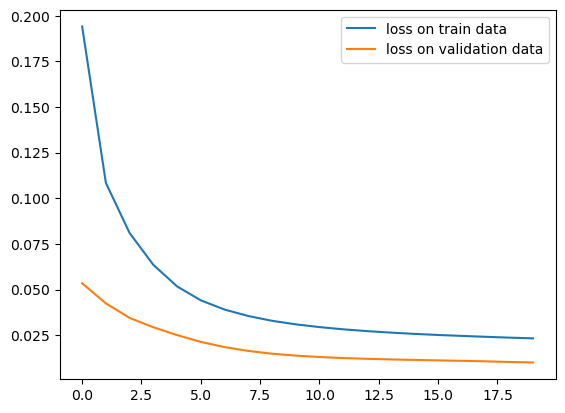

In [17]:
# Plot the training results
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

### Step 6: Calculate Reconstruction Scores and Evaluate Results

Let's first take a look at the reconstruction scores for the training set:

In [18]:
# Reconstruct the data using our autoencoder model.
X_train_pred = autoencoder_model.predict(X_train)

# the reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_scores = np.mean((X_train_pred - X_train)**2, axis=1)

I0000 00:00:1745633537.469466   18870 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_33', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1745633538.406532   18882 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_62', 20 bytes spill stores, 20 bytes spill loads



23696/23696 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step


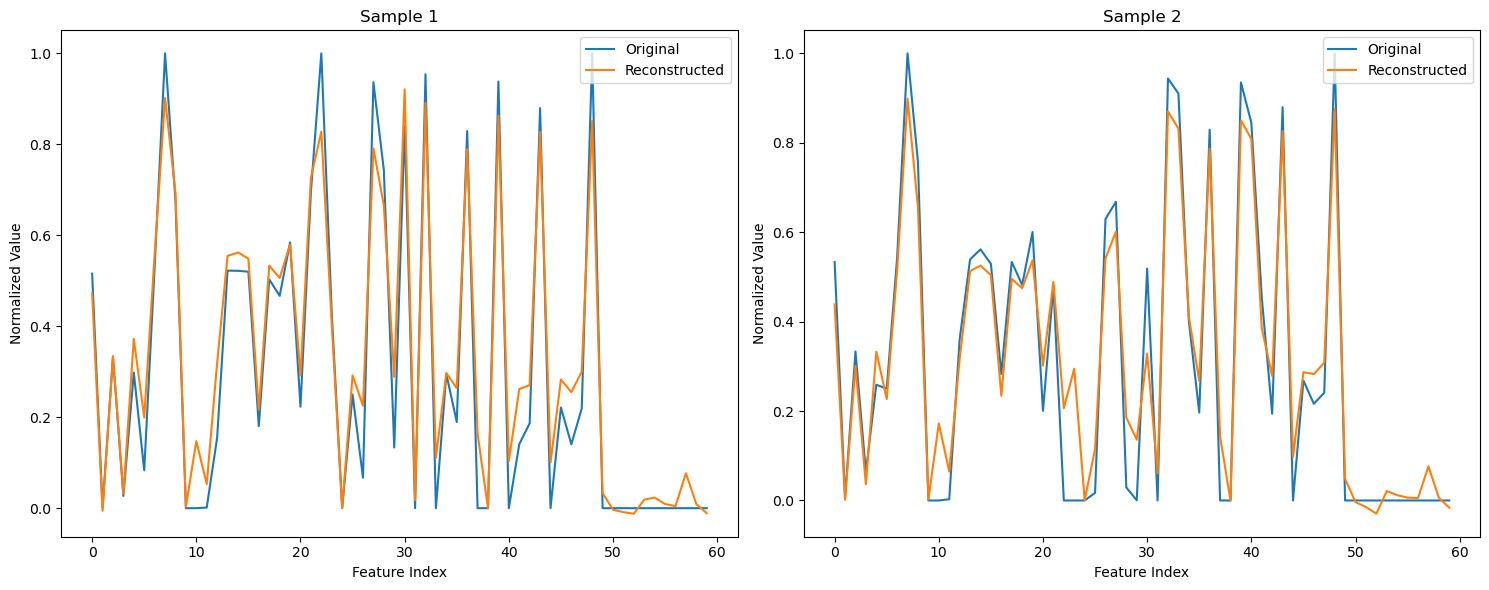

In [19]:
# Show a couple of reconstructed samples
n_samples = 2
plt.figure(figsize=(15, 6))  # Make the plot wider

for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.plot(X_train[i], label='Original')
    plt.plot(X_train_pred[i], label='Reconstructed')
    plt.legend()
    plt.title(f"Sample {i+1}")
    plt.xlabel("Feature Index")
    plt.ylabel("Normalized Value")

plt.tight_layout()

                count      mean       std  ...       50%       75%       max
recon_score  758267.0  0.010067  0.006892  ...  0.007684  0.010977  0.094873

[1 rows x 8 columns]


<Axes: ylabel='Frequency'>

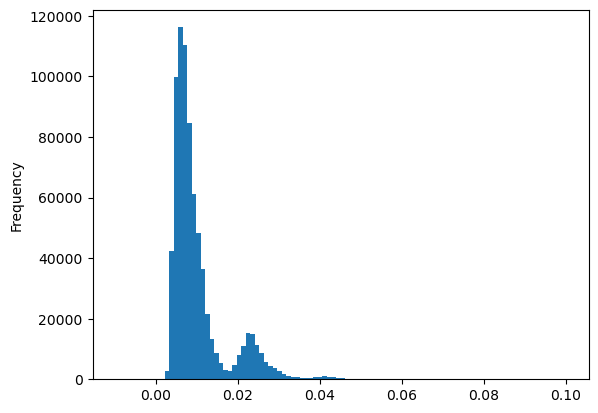

In [20]:
# plotting the density will give us an idea of how the reconstruction scores are distributed
plt.xlabel('Reconstruction Score')
reconstructed_df = pd.DataFrame({'recon_score':reconstruction_scores})
print(reconstructed_df.describe().T)
reconstructed_df['recon_score'].plot.hist(bins=100, range=[-.01, .10])

Alright, seems like the model is doing a pretty good job of reconstructing the normal samples.  Now let's get reconstruction scores for the full test data set (normal data + anomaly data), and find the optimal threshold by looking at the ROC curve.

In [21]:
# Reconstruct the data using our trainined autoencoder model.
X_test_recon = autoencoder_model.predict(X_test)
# the reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_test_scores = np.mean((X_test - X_test_recon)**2, axis=1)

# use df to get stats
reconstructed_test_df = pd.DataFrame({'recon_score':reconstruction_test_scores, 'anomaly':y_test})
print(reconstructed_test_df.head(10))
print(reconstructed_test_df.describe().T)

# Also get statistics for normal and anomaly classes separately
normal_stats = reconstructed_test_df[reconstructed_test_df['anomaly'] == 0]['recon_score'].describe()
anomaly_stats = reconstructed_test_df[reconstructed_test_df['anomaly'] == 1]['recon_score'].describe()

print("\nNormal samples reconstruction scores:")
print(normal_stats)
print("\nAnomalous samples reconstruction scores:")
print(anomaly_stats)

3701/3701 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
   recon_score  anomaly
0     0.006486      0.0
1     0.007179      0.0
2     0.015068      0.0
3     0.004498      0.0
4     0.046605      0.0
5     0.027619      0.0
6     0.005286      0.0
7     0.005660      0.0
8     0.004967      0.0
9     0.008297      0.0
                count      mean       std  ...      50%       75%       max
recon_score  118423.0  0.010092  0.006887  ...  0.00766  0.011056  0.078888
anomaly      118423.0  0.199615  0.399713  ...  0.00000  0.000000  1.000000

[2 rows x 8 columns]

Normal samples reconstruction scores:
count    94784.000000
mean         0.010032
std          0.006826
min          0.002267
25%          0.005823
50%          0.007674
75%          0.010955
max          0.078888
Name: recon_score, dtype: float64

Anomalous samples reconstruction scores:
count    23639.000000
mean         0.010334
std          0.007123
min          0.002726
25%          0.005546
50%          0.007602
75%          0.01147

<Axes: ylabel='Frequency'>

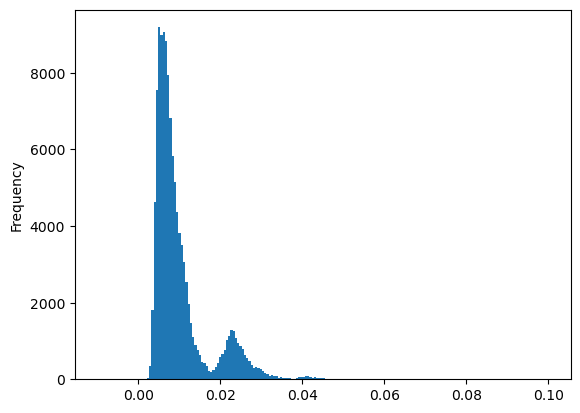

In [22]:
plt.xlabel('Reconstruction Score')
reconstructed_test_df['recon_score'].plot.hist(bins=200, range=[-.01, .10])

This is not a good sign.  This distribution looks very similar to that of the normal data only, meaning there's not a clear threshold or separation boundary in terms of overall reconstruction error.

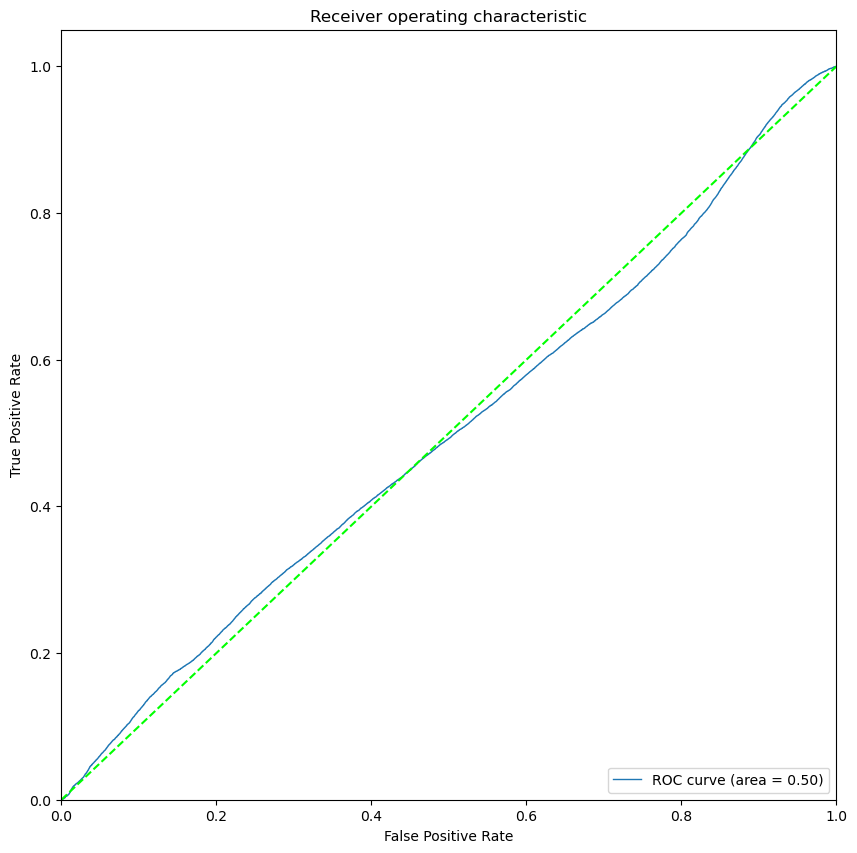

In [23]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_test_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



I had a lot of trouble getting the network to do better than 50% on the ROC curve in detecting normal data vs anomalies.  It seems the normal data and anomaly data are so similar, at least with the subset I used for training, that the detection network is no better at classifying than a random guess/coin flip.

I tried a handful of different approaches, without much success in improving the ROC scores:
- Using PCA to identify the top 20 features, and only including those in the model training process
- Playing with the autoencoder network size, and number of hyperparameters, activation method, etc.  I found a larger network to do slightly better than a smaller network (like the one in Lecture 3c), so I went with that approach.
- Normalization of the numerical data, and one-hot encoding the primary_use category to see if that information helped in identify anomalies (it didn't seem to have much of an impact)
- Training the model with just the normal data, vs with normal and anomaly data included (just training on the normal data makes the most sense to me since we want to minimize the error for normal data points and ideally the anomalies stand out, but that didn't seem to make much of a difference either)
- Changing out the scaler type (RobustScaler vs MinMaxScaler), the results were about the same or worse

So, I looked around and decided to try looking at the feature-level reconstruction errors to see if anything stood out.  It looks like there's a bit more information there, in the difference between normal vs anomaly errors for a handful of features:

Features with highest reconstruction error difference (anomaly vs normal):
Feature 31: 0.030159
Feature 30: 0.004296
Feature 52: 0.003750
Feature 1: 0.003026
Feature 51: 0.002755
Feature 27: 0.002482
Feature 23: 0.001769
Feature 2: 0.001648
Feature 22: 0.001519
Feature 55: 0.001468


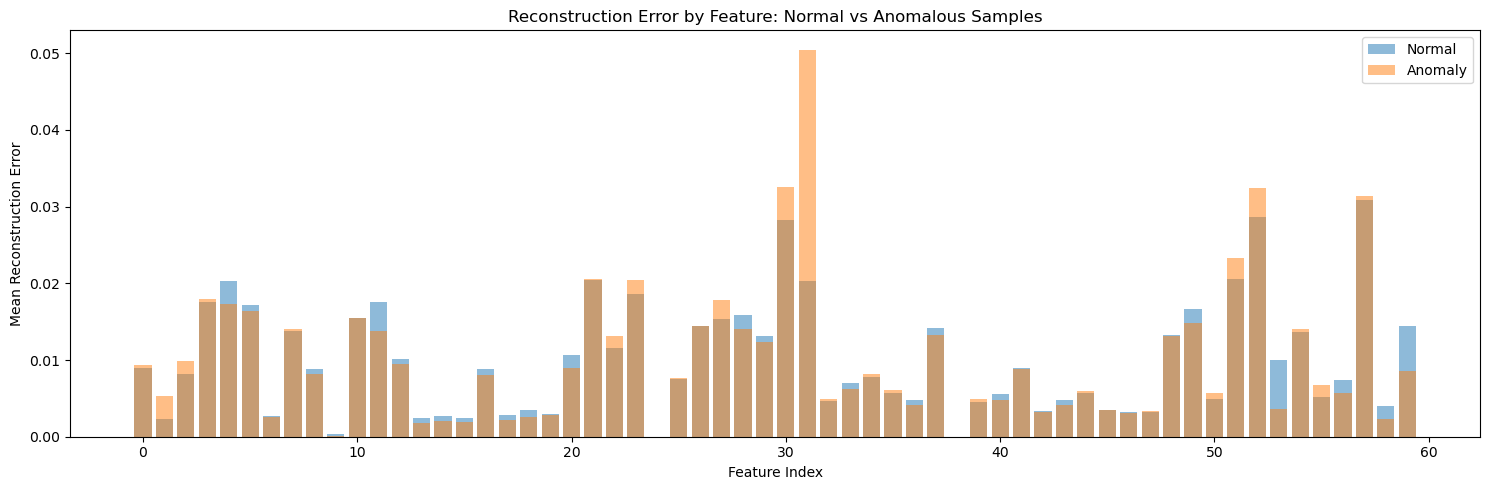

In [24]:
# Reconstruct the data using our trainined autoencoder model.
feature_errors = (X_test - X_test_recon)**2  # Square error for each feature of each sample

# Get mean error per feature across all samples
feature_mean_errors = np.mean(feature_errors, axis=0)

# Compare feature errors between normal and anomalous samples
normal_feature_errors = np.mean(feature_errors[y_test == 0], axis=0)
anomaly_feature_errors = np.mean(feature_errors[y_test == 1], axis=0)

plt.figure(figsize=(15, 5))
plt.bar(range(len(normal_feature_errors)), normal_feature_errors, alpha=0.5, label='Normal')
plt.bar(range(len(anomaly_feature_errors)), anomaly_feature_errors, alpha=0.5, label='Anomaly')
plt.xlabel('Feature Index')
plt.ylabel('Mean Reconstruction Error')
plt.title('Reconstruction Error by Feature: Normal vs Anomalous Samples')
plt.legend()
plt.tight_layout()

# Find the top N features with highest error difference
feature_error_diff = anomaly_feature_errors - normal_feature_errors
top_features_idx = np.argsort(feature_error_diff)[-10:]  # Top 10 features

print("Features with highest reconstruction error difference (anomaly vs normal):")
for i, idx in enumerate(reversed(top_features_idx)):
    print(f"Feature {idx}: {feature_error_diff[idx]:.6f}")

It looks like there is a case to be made here to look at just the difference between some reconstruction scores on a few features, to try to better classify normal vs anomaly data.  In particular, index 31 has a pretty big gap in reconstruction error.  Using the top 3 feature differences, we can get a little bit of improvement:

Using top 3 features with highest error differences: [31, 52, 30]


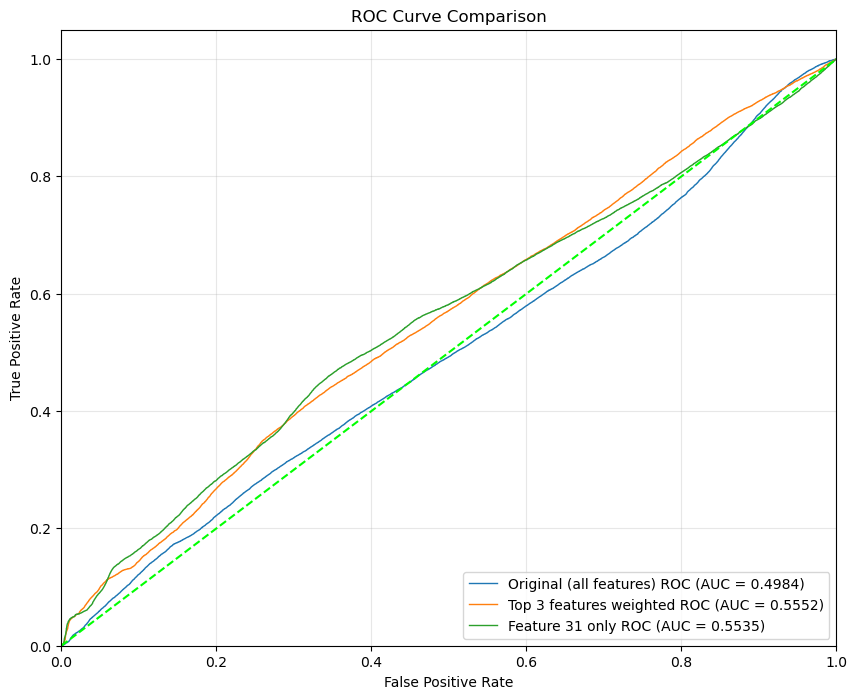

Top 3 weighted optimal threshold: 0.006827
Feature 31 only optimal threshold: 0.000918

Classification results using Top 3 weighted features:
              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75     94784
         1.0       0.24      0.41      0.31     23639

    accuracy                           0.63    118423
   macro avg       0.53      0.55      0.53    118423
weighted avg       0.71      0.63      0.66    118423



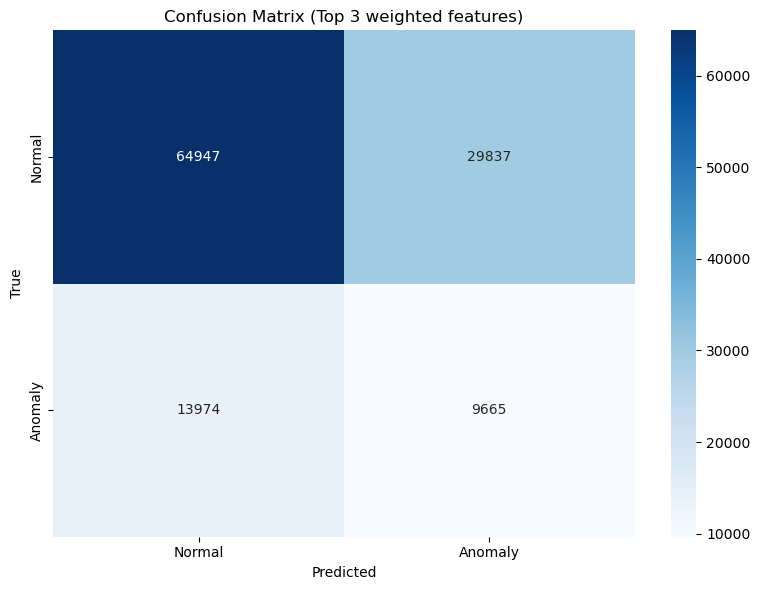

In [25]:
top_3_features = [31, 52, 30]
print(f"Using top 3 features with highest error differences: {top_3_features}")

# Get reconstruction errors for just these features
top_3_feature_errors = feature_errors[:, top_3_features]

# Method 1: Weighted combination of the top 3 features
weights = np.array([0.030261, 0.004473, 0.004289])  # Error differences as weights
normalized_weights = weights / np.sum(weights)
weighted_scores = np.sum(top_3_feature_errors * normalized_weights, axis=1)

# Method 2: Just use feature 31 which has much higher discriminative power
feature_31_scores = feature_errors[:, 31]

# Calculate ROC curves for all approaches
fpr_weighted, tpr_weighted, thresholds_weighted = roc_curve(y_test, weighted_scores)
roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
fpr_feature31, tpr_feature31, thresholds_feature31 = roc_curve(y_test, feature_31_scores)
roc_auc_feature31 = auc(fpr_feature31, tpr_feature31)

# Plot comparison of ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, lw=1, label=f'Original (all features) ROC (AUC = {roc_auc:.4f})')
plt.plot(fpr_weighted, tpr_weighted, lw=1, label=f'Top 3 features weighted ROC (AUC = {roc_auc_weighted:.4f})')
plt.plot(fpr_feature31, tpr_feature31, lw=1, label=f'Feature 31 only ROC (AUC = {roc_auc_feature31:.4f})')
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal thresholds
optimal_idx_weighted = np.argmax(tpr_weighted - fpr_weighted)
optimal_threshold_weighted = thresholds_weighted[optimal_idx_weighted]
optimal_idx_feature31 = np.argmax(tpr_feature31 - fpr_feature31)
optimal_threshold_feature31 = thresholds_feature31[optimal_idx_feature31]

print(f"Top 3 weighted optimal threshold: {optimal_threshold_weighted:.6f}")
print(f"Feature 31 only optimal threshold: {optimal_threshold_feature31:.6f}")

# Make predictions using the best method (based on highest AUC)
if roc_auc_weighted > roc_auc_feature31:
    best_scores = weighted_scores
    best_threshold = optimal_threshold_weighted
    best_method = "Top 3 weighted features"
else:
    best_scores = feature_31_scores
    best_threshold = optimal_threshold_feature31
    best_method = "Feature 31 only"

y_pred = (best_scores > best_threshold).astype(int)

# Print classification metrics
print(f"\nClassification results using {best_method}:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix ({best_method})')
plt.tight_layout()
plt.show()


In conclusion, I'm disappointed by the performance of the autoencoder network, but maybe another method would be more effective such as GANs or even a simpler clustering/support vector approach.  I did still learn a lot from the trial and error and troubleshooting I had to do in order to gain better results and get greater insight into the data.  I'm not sure if it was intended to be so difficult (or even impossible) to accurately classify normal vs anomaly samples, but I'd be very interested to know if there are better approaches, or patterns in the data that I overlooked in my analysis.